In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('jamb_exam_results.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

df = df.drop('student_id', axis=1)

df = df.fillna(0)
df.head()

,jamb_score,study_hours_per_week,attendance_rate,teacher_quality,distance_to_school,school_type,school_location,extra_tutorials,access_to_learning_materials,parent_involvement,it_knowledge,age,gender,socioeconomic_status,parent_education_level,assignments_completed
0,192,22,78,4,12.4,Public,Urban,Yes,Yes,High,Medium,17,Male,Low,Tertiary,2
1,207,14,88,4,2.7,Public,Rural,No,Yes,High,High,15,Male,High,0,1
2,182,29,87,2,9.6,Public,Rural,Yes,Yes,High,Medium,20,Female,High,Tertiary,2
3,210,29,99,2,2.6,Public,Urban,No,Yes,Medium,High,22,Female,Medium,Tertiary,1
4,199,12,98,3,8.8,Public,Urban,No,Yes,Medium,Medium,22,Female,Medium,Tertiary,1


In [3]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

print(f"Train: {len(df_train)}, Validation: {len(df_val)}, Test: {len(df_test)}")

Train: 3000, Validation: 1000, Test: 1000


In [4]:
y_train = df_train.jamb_score.values
y_val = df_val.jamb_score.values
y_test = df_test.jamb_score.values

del df_train['jamb_score']
del df_val['jamb_score']
del df_test['jamb_score']

In [5]:
train_dict = df_train.to_dict(orient='records')
val_dict = df_val.to_dict(orient='records')

dv = DictVectorizer(sparse=True)
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)

**Вопрос 1**  
**Какой признак используется для разбиения данных?**

In [6]:
dt = DecisionTreeRegressor(max_depth=1, random_state=1)
dt.fit(X_train, y_train)

feature_names = dv.get_feature_names_out()
feature_used = feature_names[dt.tree_.feature[0]]

print(f"Признак для разбиения - {feature_used}")

Признак для разбиения - study_hours_per_week


**Ответ: study_hours_per_week**

**Вопрос 2**  
**Какое значение RMSE у этой модели на валидационных данных?**

In [7]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

print(f"RMSE = {rmse:.2f}")

RMSE = 42.14


**Ответ: 42.14**

**Вопрос 3**  
**После какого значения n_estimators RMSE перестает улучшаться?**

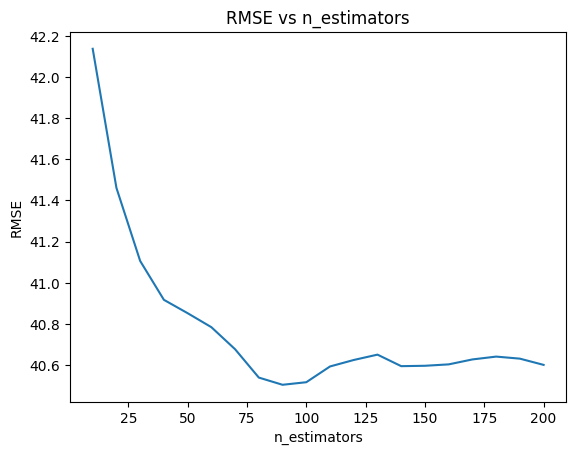

RMSE перестает улучшаться после 90 деревьев


In [11]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    scores.append((n, rmse))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

plt.plot(df_scores.n_estimators, df_scores.rmse)
plt.title('RMSE vs n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('RMSE')
plt.show()

min_rmse = df_scores.rmse.min()
threshold = min_rmse + 0.001
stopping_point = df_scores[df_scores.rmse <= threshold]['n_estimators'].min()

print(f"RMSE перестает улучшаться после {stopping_point} деревьев")

**Ответ: 90**

**Вопрос 4**  
**Какое значение max_depth оказалось лучшим по среднему RMSE?**

In [9]:
best_score = float('inf')
best_depth = None

for depth in [10, 15, 20, 25]:
    depth_scores = []

    for n in range(10, 201, 10):
        rf = RandomForestRegressor(
            n_estimators=n,
            max_depth=depth,
            random_state=1,
            n_jobs=-1
        )
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        depth_scores.append(rmse)

    mean_rmse = np.mean(depth_scores)
    print(f"max_depth={depth}, средний RMSE={mean_rmse:.3f}")

    if mean_rmse < best_score:
        best_score = mean_rmse
        best_depth = depth

print(f"max_depth = {best_depth}")

max_depth=10, средний RMSE=40.392
max_depth=15, средний RMSE=40.735
max_depth=20, средний RMSE=40.740
max_depth=25, средний RMSE=40.788
max_depth = 10


**Ответ: 10**

**Вопрос 5**  
**Какой признак оказался самым важным:**
*   study_hours_per_week
*   attendance_rate
*   distance_to_school
*   teacher_quality?

In [10]:
rf_final = RandomForestRegressor(
    n_estimators=10,
    max_depth=20,
    random_state=1,
    n_jobs=-1
)
rf_final.fit(X_train, y_train)

# Получение важности признаков
importances = rf_final.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

print("Топ-5 самых важных признаков:")
print(feature_importance_df.head())

specified_features = [
    'study_hours_per_week',
    'attendance_rate',
    'distance_to_school',
    'teacher_quality'
]

most_important_specified = None
max_importance = 0

for feature in specified_features:
    feature_row = feature_importance_df[feature_importance_df['feature'].str.contains(feature)]
    if not feature_row.empty:
        importance = feature_row['importance'].values[0]
        if importance > max_importance:
            max_importance = importance
            most_important_specified = feature

print(f"Самый важный признак(из заданны) - {most_important_specified}")

Топ-5 самых важных признаков:
                 feature  importance
27  study_hours_per_week    0.248354
4        attendance_rate    0.149729
5     distance_to_school    0.136486
28       teacher_quality    0.082682
2                    age    0.069311
Самый важный признак(из заданны) - study_hours_per_week


**Ответ: study_hours_per_week**